In this project we will cover and combine a number of machine learning tools to get a prediction of default for personal loans.

The steps used will be as follows:
* Import the data into pandas.
* use feature tools for feature generation.
* run some basic clustering to see if we can get some useful grouping.
* run a decison tree to simulate segmentaion reasons.
* Run logistic regression as a classifier using these clusters as features.
* compare how this segmented logistic regression works vs overall logistic regression and a neural network.

During this project we will be using Pandas and SKLearn packages. This should not bee seen as tutorial but rather a showcase of what is possible.


# Importing data and feature generation

For this project data from Home Credit Group  will be used. Home Credit is a chinese lender aiming to target the unbanked consumer. This has lead them to use a range of alternative data sources as well as traditional financial metrics.

The datasets below are for a personal loans portfolio with a defined "TARGET" field that indicated if the loan has defaulted or not. The relationships between the datasets are defined according to this diagram.

<b>Solid line = one to one relationship</b>

<b>Dashed line =  one to many relationship</b>

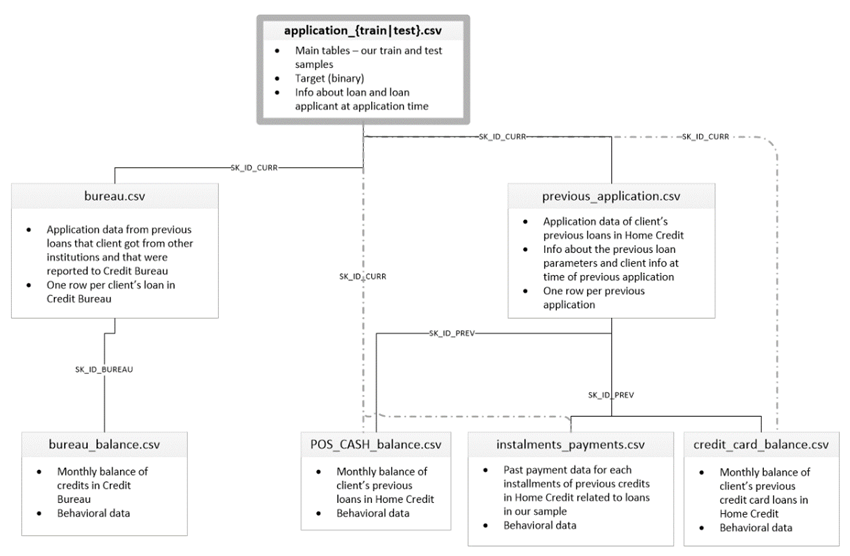

## Import data

All of these datasets will need to be imported and added to the feature tools entityset. These 2 stages will be carried out at the same time to help avoid processing errors due to memory constraints. 

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
data_location = 'C:\\Users\\luken\\Documents\\Home Credit Group\\Data\\'

In [6]:
# Read in Training data
apps = pd.read_csv(data_location+'application_train.csv', delimiter=',', encoding="utf-8-sig")
apps.set_index(apps.SK_ID_CURR.values, inplace=True)
apps.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
363002,363002,0,Cash loans,F,N,N,1,225000.0,352422.0,30244.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
142849,142849,0,Cash loans,F,N,Y,1,99000.0,755190.0,36459.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
257805,257805,0,Cash loans,F,N,Y,0,90000.0,547344.0,17919.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
214301,214301,0,Cash loans,F,N,Y,0,247500.0,578979.0,27981.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
413894,413894,0,Cash loans,M,Y,Y,0,180000.0,755190.0,32125.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
108044,108044,0,Cash loans,M,N,Y,0,247500.0,1479024.0,40801.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
453503,453503,0,Cash loans,M,Y,Y,2,270000.0,563877.0,23890.5,...,0,0,0,0,0.0,0.0,0.0,1.0,2.0,3.0
446117,446117,0,Revolving loans,F,N,Y,0,675000.0,675000.0,33750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
241997,241997,0,Cash loans,F,Y,Y,1,90000.0,343800.0,16852.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
375738,375738,0,Cash loans,M,N,Y,1,157500.0,180000.0,10462.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [7]:
# We define one entitySet and then add all the tables to that set as entities using the .funtion format
es = ft.EntitySet(id = 'applications')

es = es.entity_from_dataframe(entity_id = 'apps'
                             ,dataframe=apps
                             ,index='SK_ID_CURR'
#                              ,time_index="" #If you wanted to use some wime series data (ie 1 record per month per loan) this would be where it is defined. For simplicity I am ignoring this for our example.
#                              ,varible_types={""}  #This is where you would define the specific data types but the inferred type is pretty good for this dataset
                             )

#Print out varible to confirm everything worked fine
es['apps'].variables

[<Variable: SK_ID_CURR (dtype = index)>,
 <Variable: TARGET (dtype = numeric)>,
 <Variable: NAME_CONTRACT_TYPE (dtype = categorical)>,
 <Variable: CODE_GENDER (dtype = categorical)>,
 <Variable: FLAG_OWN_CAR (dtype = categorical)>,
 <Variable: FLAG_OWN_REALTY (dtype = categorical)>,
 <Variable: CNT_CHILDREN (dtype = numeric)>,
 <Variable: AMT_INCOME_TOTAL (dtype = numeric)>,
 <Variable: AMT_CREDIT (dtype = numeric)>,
 <Variable: AMT_ANNUITY (dtype = numeric)>,
 <Variable: AMT_GOODS_PRICE (dtype = numeric)>,
 <Variable: NAME_TYPE_SUITE (dtype = categorical)>,
 <Variable: NAME_INCOME_TYPE (dtype = categorical)>,
 <Variable: NAME_EDUCATION_TYPE (dtype = categorical)>,
 <Variable: NAME_FAMILY_STATUS (dtype = categorical)>,
 <Variable: NAME_HOUSING_TYPE (dtype = categorical)>,
 <Variable: REGION_POPULATION_RELATIVE (dtype = numeric)>,
 <Variable: DAYS_BIRTH (dtype = numeric)>,
 <Variable: DAYS_EMPLOYED (dtype = numeric)>,
 <Variable: DAYS_REGISTRATION (dtype = numeric)>,
 <Variable: DAYS_ID

In [8]:
bur = pd.read_csv(data_location+'bureau.csv', delimiter=',', encoding="utf-8-sig")
bur.set_index(bur.SK_ID_CURR.values, inplace=True)


bur_size = bur.shape[0]
print('Bur has '+str(bur_size)+' records.')

es = es.entity_from_dataframe(entity_id = 'bur'
                             ,dataframe=bur
                             ,index= 'SK_ID_BUREAU'
                             )
#Print out varible to confirm everything worked fine
es['bur'].variables

Bur has 1716428 records.


[<Variable: SK_ID_BUREAU (dtype = index)>,
 <Variable: SK_ID_CURR (dtype = numeric)>,
 <Variable: CREDIT_ACTIVE (dtype = categorical)>,
 <Variable: CREDIT_CURRENCY (dtype = categorical)>,
 <Variable: DAYS_CREDIT (dtype = numeric)>,
 <Variable: CREDIT_DAY_OVERDUE (dtype = numeric)>,
 <Variable: DAYS_CREDIT_ENDDATE (dtype = numeric)>,
 <Variable: DAYS_ENDDATE_FACT (dtype = numeric)>,
 <Variable: AMT_CREDIT_MAX_OVERDUE (dtype = numeric)>,
 <Variable: CNT_CREDIT_PROLONG (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM_DEBT (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM_LIMIT (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM_OVERDUE (dtype = numeric)>,
 <Variable: CREDIT_TYPE (dtype = categorical)>,
 <Variable: DAYS_CREDIT_UPDATE (dtype = numeric)>,
 <Variable: AMT_ANNUITY (dtype = numeric)>]

##### NOTE: For one to many relationships we do not have a suitable index that feature tools will accept (it only likes 1 to 1) so we have to define a new one. This is not the index for the table only internal to feature tools.

In [9]:
bur_bal = pd.read_csv(data_location+'bureau_balance.csv', delimiter=',', encoding="utf-8-sig")
bur_bal.set_index(bur_bal.SK_ID_BUREAU.values, inplace=True)

bur_bal_size = bur_bal.shape[0]
print('Bur_bal has '+str(bur_bal_size)+' records.')

es = es.entity_from_dataframe(entity_id = 'bur_bal'
                             ,dataframe=bur_bal
                             ,make_index = True ## New Index
                             ,index= 'bur_bal_index'
                             )

es['bur_bal'].variables

Bur_bal has 27299925 records.


[<Variable: bur_bal_index (dtype = index)>,
 <Variable: SK_ID_BUREAU (dtype = numeric)>,
 <Variable: MONTHS_BALANCE (dtype = numeric)>,
 <Variable: STATUS (dtype = categorical)>]

##### NOTE: Despite this being a 1 to many relationship we do have a useable key(index), so we don't need to define a new key.

In [10]:
pre_app = pd.read_csv(data_location+'previous_application.csv', delimiter=',', encoding="utf-8-sig")
pre_app.set_index(pre_app.SK_ID_PREV.values, inplace=True)

pre_app_size = pre_app.shape[0]
print('Pre app ' + str(pre_app_size) + ' records.')

es = es.entity_from_dataframe(entity_id = 'pre_app'
                             ,dataframe=pre_app
                             ,index='SK_ID_PREV'
                             )

es['pre_app'].variables

Pre app 1670214 records.


[<Variable: SK_ID_PREV (dtype = index)>,
 <Variable: SK_ID_CURR (dtype = numeric)>,
 <Variable: NAME_CONTRACT_TYPE (dtype = categorical)>,
 <Variable: AMT_ANNUITY (dtype = numeric)>,
 <Variable: AMT_APPLICATION (dtype = numeric)>,
 <Variable: AMT_CREDIT (dtype = numeric)>,
 <Variable: AMT_DOWN_PAYMENT (dtype = numeric)>,
 <Variable: AMT_GOODS_PRICE (dtype = numeric)>,
 <Variable: WEEKDAY_APPR_PROCESS_START (dtype = categorical)>,
 <Variable: HOUR_APPR_PROCESS_START (dtype = numeric)>,
 <Variable: FLAG_LAST_APPL_PER_CONTRACT (dtype = categorical)>,
 <Variable: NFLAG_LAST_APPL_IN_DAY (dtype = numeric)>,
 <Variable: RATE_DOWN_PAYMENT (dtype = numeric)>,
 <Variable: RATE_INTEREST_PRIMARY (dtype = numeric)>,
 <Variable: RATE_INTEREST_PRIVILEGED (dtype = numeric)>,
 <Variable: NAME_CASH_LOAN_PURPOSE (dtype = categorical)>,
 <Variable: NAME_CONTRACT_STATUS (dtype = categorical)>,
 <Variable: DAYS_DECISION (dtype = numeric)>,
 <Variable: NAME_PAYMENT_TYPE (dtype = categorical)>,
 <Variable: CO

In [11]:
pos_cash = pd.read_csv(data_location+'POS_CASH_balance.csv', delimiter=',', encoding="utf-8-sig")
pos_cash.set_index(pos_cash.SK_ID_PREV.values, inplace=True)

pos_cash_size = pos_cash.shape[0]
print('pos_cash ' + str(pos_cash_size) + ' records.')


# Since we dont have a unique key for the payments table we need to specify the make_index=True function and specify a name
es = es.entity_from_dataframe(entity_id = 'pos_cash'
                             ,dataframe=pos_cash
                             ,make_index = True 
                             ,index= 'cash_index'
                             )

es['pos_cash'].variables

pos_cash 10001358 records.


[<Variable: cash_index (dtype = index)>,
 <Variable: SK_ID_PREV (dtype = numeric)>,
 <Variable: SK_ID_CURR (dtype = numeric)>,
 <Variable: MONTHS_BALANCE (dtype = numeric)>,
 <Variable: CNT_INSTALMENT (dtype = numeric)>,
 <Variable: CNT_INSTALMENT_FUTURE (dtype = numeric)>,
 <Variable: NAME_CONTRACT_STATUS (dtype = categorical)>,
 <Variable: SK_DPD (dtype = numeric)>,
 <Variable: SK_DPD_DEF (dtype = numeric)>]

In [12]:
install_pay = pd.read_csv(data_location+'installments_payments.csv', delimiter=',', encoding="utf-8-sig")
install_pay.set_index(install_pay.SK_ID_PREV.values, inplace=True)
install_pay_size = install_pay.shape[0]

print('install_pay ' + str(install_pay_size) + ' records.')


# Since we do not have a unique key for the payments table we need to specify the make_index=True function and specify a name
es = es.entity_from_dataframe(entity_id = 'install_pay'
                             ,dataframe=install_pay.reset_index()
                             ,make_index = True 
                             ,index= 'pay_index'
                             )

es['install_pay'].variables



install_pay 13605401 records.


[<Variable: pay_index (dtype = index)>,
 <Variable: index (dtype = numeric)>,
 <Variable: SK_ID_PREV (dtype = numeric)>,
 <Variable: SK_ID_CURR (dtype = numeric)>,
 <Variable: NUM_INSTALMENT_VERSION (dtype = numeric)>,
 <Variable: NUM_INSTALMENT_NUMBER (dtype = numeric)>,
 <Variable: DAYS_INSTALMENT (dtype = numeric)>,
 <Variable: DAYS_ENTRY_PAYMENT (dtype = numeric)>,
 <Variable: AMT_INSTALMENT (dtype = numeric)>,
 <Variable: AMT_PAYMENT (dtype = numeric)>]

In [13]:
cc_bal = pd.read_csv(data_location+'credit_card_balance.csv', delimiter=',', encoding="utf-8-sig")
cc_bal.set_index(cc_bal.SK_ID_PREV.values, inplace=True)

cc_bal_size = cc_bal.shape[0]
print('cc_bal ' + str(cc_bal_size) + ' records.')


# Since we do not have a unique key for the payments table we need to specify the make_index=True function and specify a name
# Note this key is not for merging just for internal feature tools work
es = es.entity_from_dataframe(entity_id = 'cc_bal'
                             ,dataframe=cc_bal.reset_index()
                             ,make_index = True 
                             ,index= 'cc_bal_index'
                             )

es['cc_bal'].variables


cc_bal 3840312 records.


[<Variable: cc_bal_index (dtype = index)>,
 <Variable: index (dtype = numeric)>,
 <Variable: SK_ID_PREV (dtype = numeric)>,
 <Variable: SK_ID_CURR (dtype = numeric)>,
 <Variable: MONTHS_BALANCE (dtype = numeric)>,
 <Variable: AMT_BALANCE (dtype = numeric)>,
 <Variable: AMT_CREDIT_LIMIT_ACTUAL (dtype = numeric)>,
 <Variable: AMT_DRAWINGS_ATM_CURRENT (dtype = numeric)>,
 <Variable: AMT_DRAWINGS_CURRENT (dtype = numeric)>,
 <Variable: AMT_DRAWINGS_OTHER_CURRENT (dtype = numeric)>,
 <Variable: AMT_DRAWINGS_POS_CURRENT (dtype = numeric)>,
 <Variable: AMT_INST_MIN_REGULARITY (dtype = numeric)>,
 <Variable: AMT_PAYMENT_CURRENT (dtype = numeric)>,
 <Variable: AMT_PAYMENT_TOTAL_CURRENT (dtype = numeric)>,
 <Variable: AMT_RECEIVABLE_PRINCIPAL (dtype = numeric)>,
 <Variable: AMT_RECIVABLE (dtype = numeric)>,
 <Variable: AMT_TOTAL_RECEIVABLE (dtype = numeric)>,
 <Variable: CNT_DRAWINGS_ATM_CURRENT (dtype = numeric)>,
 <Variable: CNT_DRAWINGS_CURRENT (dtype = numeric)>,
 <Variable: CNT_DRAWINGS_OTH

### Define Relationships between the datasets

From the data scheme above we have 6 relationships defined:
* One application record has one record in the bureau dataset (1 to 1).
* One bureau record has one record in the bureau balance dataset (1 to 1).
* One application record can have more than one record in the previous application dataset (1 to Many).
* One previous application record will have many PSO Cash Balance records. (1 to Many)
* One previous application record will have many installments records. (1 to Many)
* One previous application record will have many Credit Card Balance records. (1 to Many)

It is worth noting that we are prioritising the 1 to 1 relationships over the 1 to many. (i.e.  Not defining the relationship between application and pos_cash_balance.) This is to avoid memory errors by reducing the number of features that will be generated that are subsets of previously generated features.

In [14]:
# ft.Relationship(entityset1['common key'], entityset2['common key'])

rel_app_to_bur = ft.Relationship(es['apps']['SK_ID_CURR']
                                ,es['bur']['SK_ID_CURR'])

rel_bur_to_bur_bal = ft.Relationship(es['bur']['SK_ID_BUREAU']
                                    ,es['bur_bal']['SK_ID_BUREAU'])


rel_app_to_pre_app = ft.Relationship(es['apps']['SK_ID_CURR']
                                     ,es['pre_app']['SK_ID_CURR'])

rel_pre_app_to_cash = ft.Relationship(es['pre_app']['SK_ID_PREV']
                                     ,es['pos_cash']['SK_ID_PREV'])

rel_pre_app_to_install = ft.Relationship(es['pre_app']['SK_ID_PREV']
                                        ,es['install_pay']['SK_ID_PREV'])

rel_pre_app_to_cc_bal = ft.Relationship(es['pre_app']['SK_ID_PREV']
                                       ,es['cc_bal']['SK_ID_PREV'])

es = es.add_relationships([rel_app_to_bur
                          ,rel_bur_to_bur_bal
                           
                          ,rel_app_to_pre_app
                          ,rel_pre_app_to_cash
                          ,rel_pre_app_to_install
                          ,rel_pre_app_to_cc_bal])
#Print out the entityset
es

Entityset: applications
  Entities:
    apps [Rows: 307511, Columns: 122]
    bur [Rows: 1716428, Columns: 17]
    bur_bal [Rows: 27299925, Columns: 4]
    pre_app [Rows: 1670214, Columns: 37]
    pos_cash [Rows: 10001358, Columns: 9]
    install_pay [Rows: 13605401, Columns: 10]
    cc_bal [Rows: 3840312, Columns: 25]
  Relationships:
    bur.SK_ID_CURR -> apps.SK_ID_CURR
    bur_bal.SK_ID_BUREAU -> bur.SK_ID_BUREAU
    pre_app.SK_ID_CURR -> apps.SK_ID_CURR
    pos_cash.SK_ID_PREV -> pre_app.SK_ID_PREV
    install_pay.SK_ID_PREV -> pre_app.SK_ID_PREV
    cc_bal.SK_ID_PREV -> pre_app.SK_ID_PREV

### What type of feature do we want?

For each feature we need to specify what statistic we want to use and what grouping (time period) we want to calculate them on. These are called primitives and need to be defined. The statistics themselves are called agg primitives. The periods are called trans primitives. A List of primitives can be seen below.

Feature tools using its deep feature synthesis is able to calculate a huge number of statistics however this can be a double-edged sword. As too many features leads to over fitting and will increase compute time and memory requirements. Also the more exotic statistics tend to abstract away from underlying meaning making the use of them less explainable as to why it is predictive.

As stated before I have not used specified any time period for simplicities sake, so the grouping will be across all data. 

For the Agg primitive, again to keep things simple and explainable I will only use five. 
* Sum - How much of this varible has the customer experienced.
* Mean - What is the normal level of this varible for the customer.
* Standard Deviation - How consistant is the varible for the customer.
* Max/Min - What is the most stressed level that a customer has experienced. 



In [17]:
# List the primitives in a dataframe
print('List of Primitives')
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
# primitives[primitives['type'] == 'aggregation'].head(100)
primitives.head(100)

List of Primitives


,name,type,description
0,min,aggregation,Finds the minimum non-null value of a numeric feature.
1,avg_time_between,aggregation,Computes the average time between consecutive events.
2,max,aggregation,Finds the maximum non-null value of a numeric feature.
3,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
4,sum,aggregation,Sums elements of a numeric or boolean feature.
5,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
6,mode,aggregation,Finds the most common element in a categorical feature.
7,any,aggregation,Test if any value is 'True'.
8,percent_true,aggregation,Finds the percent of 'True' values in a boolean feature.
9,trend,aggregation,Calculates the slope of the linear trend of variable overtime.


In [18]:
# Perform the Deep Feature Synthesis

# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "min", "mean"]

# DFS with specified primitives
feature_matix_spec, feature_names = ft.dfs(entityset = es, target_entity = 'apps',
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2
                       ,features_only=False
                                          )

print('%d Total Features' % len(feature_names))
feature_names

1238 Total Features


[<Feature: TARGET>,
 <Feature: NAME_CONTRACT_TYPE>,
 <Feature: CODE_GENDER>,
 <Feature: FLAG_OWN_CAR>,
 <Feature: FLAG_OWN_REALTY>,
 <Feature: CNT_CHILDREN>,
 <Feature: AMT_INCOME_TOTAL>,
 <Feature: AMT_CREDIT>,
 <Feature: AMT_ANNUITY>,
 <Feature: AMT_GOODS_PRICE>,
 <Feature: NAME_TYPE_SUITE>,
 <Feature: NAME_INCOME_TYPE>,
 <Feature: NAME_EDUCATION_TYPE>,
 <Feature: NAME_FAMILY_STATUS>,
 <Feature: NAME_HOUSING_TYPE>,
 <Feature: REGION_POPULATION_RELATIVE>,
 <Feature: DAYS_BIRTH>,
 <Feature: DAYS_EMPLOYED>,
 <Feature: DAYS_REGISTRATION>,
 <Feature: DAYS_ID_PUBLISH>,
 <Feature: OWN_CAR_AGE>,
 <Feature: FLAG_MOBIL>,
 <Feature: FLAG_EMP_PHONE>,
 <Feature: FLAG_WORK_PHONE>,
 <Feature: FLAG_CONT_MOBILE>,
 <Feature: FLAG_PHONE>,
 <Feature: FLAG_EMAIL>,
 <Feature: OCCUPATION_TYPE>,
 <Feature: CNT_FAM_MEMBERS>,
 <Feature: REGION_RATING_CLIENT>,
 <Feature: REGION_RATING_CLIENT_W_CITY>,
 <Feature: WEEKDAY_APPR_PROCESS_START>,
 <Feature: HOUR_APPR_PROCESS_START>,
 <Feature: REG_REGION_NOT_LIVE_REG

In [19]:
feature_matix_spec.head(10)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,MAX(bur.MEAN(bur_bal.MONTHS_BALANCE)),MIN(bur.SUM(bur_bal.MONTHS_BALANCE)),MIN(bur.STD(bur_bal.MONTHS_BALANCE)),MIN(bur.MAX(bur_bal.MONTHS_BALANCE)),MIN(bur.MEAN(bur_bal.MONTHS_BALANCE)),MEAN(bur.SUM(bur_bal.MONTHS_BALANCE)),MEAN(bur.STD(bur_bal.MONTHS_BALANCE)),MEAN(bur.MAX(bur_bal.MONTHS_BALANCE)),MEAN(bur.MIN(bur_bal.MONTHS_BALANCE)),MEAN(bur.MEAN(bur_bal.MONTHS_BALANCE))
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,-1.5,-632.0,1.290994,-32.0,-39.5,-337.625,4.110042,-15.5,-28.25,-21.875
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,0.0,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,0.0,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,0.0,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,NaN,0.0,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,NaN,0.0,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,-19.5,-2610.0,10.535654,-55.0,-72.5,-1656.000,10.535654,-28.5,-63.50,-46.000
100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,NaN,0.0,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN


#### Data cleansing, encoding and output

The Deep feature synthesis produced over 1200 varibles that we can use for prediction. However the data quality for these varibles is not guaranteed to be the best which will cause problems when we start to implement some of the ML tools. To account for this we will replace missing/NaN (not a number) values with a specified value. I will use 0 to reduce the interaction with the scaling that needs to be applied down the line.

Additionally from the original dataset we have a number of catagorical varibles like gender code. These will need to be encoded into dummy varibles to allow for the ML tools to act on them. The reason I have waited until now to carry out this process is to avoid the dummy varibles being used in the feature synthesis process. 

As we are talking about catagorical varibles where each value is likely to be independent, we can transform the varible using one hot encoding. 

One hot encoding will create a new column on our dataset for each of the possible values a catagorical varible will take. These columns will be filled with a binary flag indicating if the value of the varible for that column was triggered. 

For example encoding gender code in this way will create 2 columns 'GENDER_CODE_M' and 'GENDER_CODE_F' each column must have a value of 1 for one of these columns but not both. 

In [20]:
# Encode the catagorical varibles with one hot 
def one_hot_encode_it(dset):

    print('The following varibles have been one hot encoded.')
    for column in dset.columns:
        if dset[column].dtype == type(object):
            x = pd.get_dummies(dset[column],prefix=column)
            dset = dset.join(x,on='SK_ID_CURR').drop(str(column),1)
            del x
            print(column)
    return dset

apps = one_hot_encode_it(feature_matix_spec)
apps.sample(10)

The following varibles have been one hot encoded.
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
315775,0,1,144000.0,942300.0,30528.0,675000.0,0.018801,-13625,-1166,-28.0,...,0,0,0,0,0,0,0,0,0,0
315341,0,2,49500.0,526491.0,28179.0,454500.0,0.018850,-15976,-1734,-8076.0,...,0,0,0,0,0,0,1,0,0,1
426940,0,0,112500.0,237024.0,15970.5,180000.0,0.018029,-9440,-469,-4170.0,...,0,0,0,0,0,0,0,0,0,0
204624,1,0,205200.0,521280.0,28408.5,450000.0,0.035792,-19660,-1258,-11699.0,...,0,0,0,0,0,0,0,0,0,0
289105,0,1,99000.0,454500.0,19386.0,454500.0,0.028663,-18257,-9887,-4028.0,...,0,0,0,0,0,0,0,0,0,0
456153,0,0,157500.0,1282500.0,48847.5,1282500.0,0.030755,-22672,365243,-8334.0,...,0,0,0,0,0,0,0,0,0,0
215264,0,1,202500.0,801000.0,26469.0,801000.0,0.006233,-15070,-3935,-4018.0,...,0,0,0,0,0,1,0,0,1,0
269689,1,0,54000.0,351000.0,21550.5,351000.0,0.035792,-18052,-2504,-5194.0,...,0,0,0,0,0,0,0,0,0,0
156352,0,0,121500.0,106974.0,11520.0,94500.0,0.024610,-20611,-95,-2067.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
apps = apps.fillna(0)

#Output the featured data
apps.to_pickle(data_location+'featured_apps.pkl')
apps.head(10)

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0
100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0
100008,0,0,99000.0,490495.5,27517.5,454500.0,0.035792,-16941,-1588,-4970.0,...,0,0,0,0,0,0,0,0,0,0
100009,0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,-13778,-3130,-1213.0,...,0,0,0,0,0,0,0,0,0,0
100010,0,0,360000.0,1530000.0,42075.0,1530000.0,0.003122,-18850,-449,-4597.0,...,0,0,0,0,0,0,0,0,0,0
100011,0,0,112500.0,1019610.0,33826.5,913500.0,0.018634,-20099,365243,-7427.0,...,0,0,0,0,0,0,0,0,0,0


# Feature Selection

Now that we have over 1300 features we need to work out which ones are useful or not. This is important for two reasons:
1. To reduce processing time training machine learning algorithms. 
2. To help reduce the possibility of over fitting on a number.
3. To help the interpretability of the result of machine learning.

###### Reducing processing time
The first is an obvious benefit especally in the development process where we could be iterating many times as we tweak parameters. Additionally with the rise in cloud computing where clients are billed on a 'Pay for what you use' basis, having less useful features in the training data has a direct cost as the compute time increases.  

###### Reducing posibility of overfitting
The second point on over fitting can be shown in the image below (fig 1) which show the ROCs from the training and test data for a neural network trained the Home Credit Data using all the features produced by feature tools and only the top 10% of features.  In the first case where all features were exposed in the training data we achieved a perfect true positive rate. However on the test data there was a significantly poorer result. This is due to the wealth of features making a highly specific classifier that is not able to generalise to the population out of the sample. 

In the second example where we have only exposed a subset of features to the network we have a much lower true positive rate BUT a much closer result between the training and test data. Meaning this classifier is actually useful outside of the training data. It is also worth noting both results for the reduced features are higher than the full features test data results. 

<i>Fig 1</i>
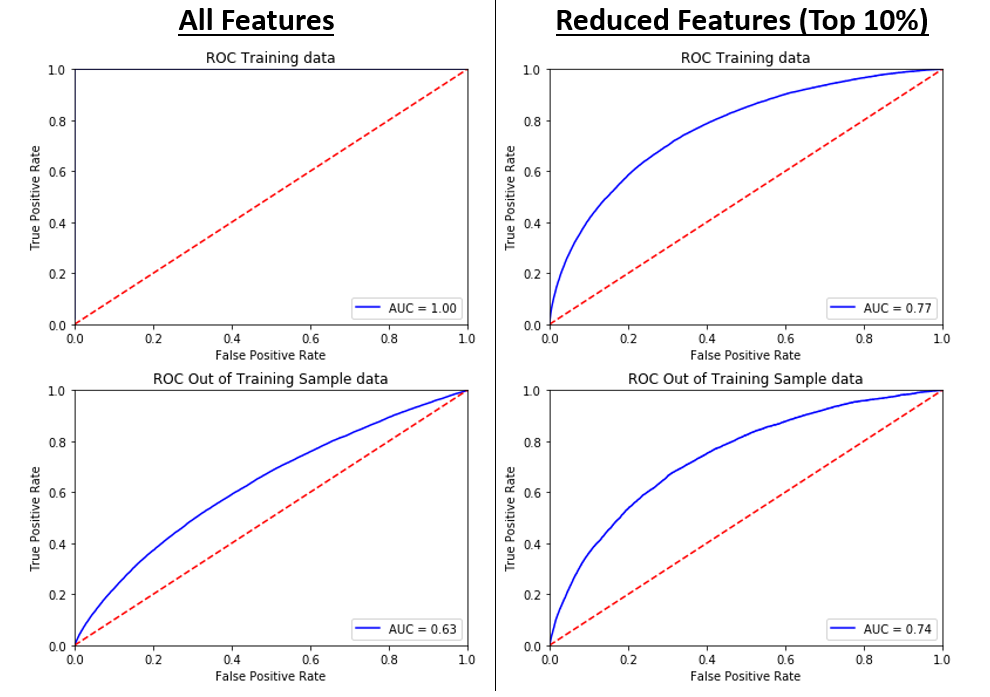

###### Increasing clarity of results

The final point on interpretability is not as clear cut. In the example of k-means clustering below (fig 2) we can see that the reduced feaures provides a much clearer picture of where the cluster boundaries are defined. The reason for this is not specifically due to the clustering but the principal component's reduction that was carried out to visualise the result. What appears to have happened is on the full feature run, principal component 1 in particular has been polluted with very uncorrelated and extreme values. This has lead to a very large range for this PC (principal component) This has rendered the x axis almost redundant in the visualisation. Reducing the number of features used will not guarantee that this situation will no longer occur, however it does reduce the likelihood. 

NB Principal components are rank ordered in terms of describing differences i.e. a one unit difference between data points on PC1 indicates more of a difference than 1 unit on PC2.

<i>Fig 2</i>
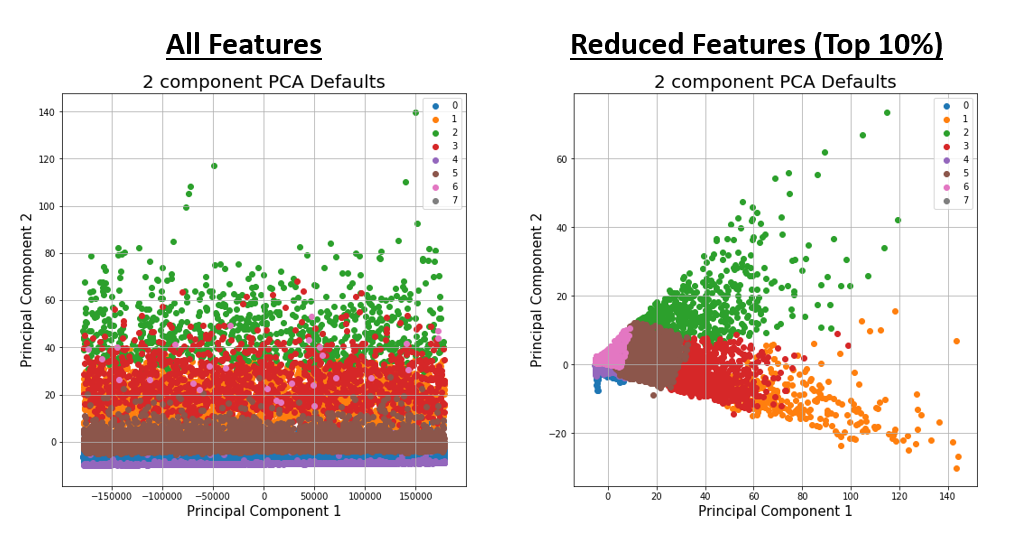

In [3]:
apps = pd.read_pickle(data_location+'featured_apps.pkl')
apps.head(10)

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0
100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0
100008,0,0,99000.0,490495.5,27517.5,454500.0,0.035792,-16941,-1588,-4970.0,...,0,0,0,0,0,0,0,0,0,0
100009,0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,-13778,-3130,-1213.0,...,0,0,0,0,0,0,0,0,0,0
100010,0,0,360000.0,1530000.0,42075.0,1530000.0,0.003122,-18850,-449,-4597.0,...,0,0,0,0,0,0,0,0,0,0
100011,0,0,112500.0,1019610.0,33826.5,913500.0,0.018634,-20099,365243,-7427.0,...,0,0,0,0,0,0,0,0,0,0


### Feature Selection in SKLearn

The feature selection method that we will be using is sklearn.feature_selection.SelectPercentile. This will select the top X% features in terms of predictive power. This predictive power is based on univariate statistics (chi squared, F-test and Mutual information). These statistics are then combined into a score for each feature and ranked accordingly.



In [4]:
from sklearn.feature_selection import SelectPercentile

select = SelectPercentile(percentile=10)
#Specify the target varible that we will test predictive power on
x_train_selected = select.fit_transform(apps, apps['TARGET'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   0  269  323  386  387  416  432  433  445  446  477  478  541  542
  565  598  606  614  644  645  666  672  682  685  686  688  715  721
  727  741  742  787  788  829  830  859  885  886  931  932 1003 1029
 1030 1083 1084 1147 1148 1177] are constant.
  UserWarning)


###### Which features were selected?

In [41]:

##Create a boolean mask
feature_mask = select.get_support()
## Get list of all features
col_list = apps.columns

##Using the mask only keep features that have been selected (True in mask)
features_selected = col_list[feature_mask]
good_features = list(features_selected)
print(str(features_selected.size)+' have been selected.')
print(good_features)



137 have been selected.
['TARGET', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'STD(pre_app.DAYS_FIRST_DRAWING)', 'SUM(bur.DAYS_CREDIT)', 'SUM(bur.DAYS_CREDIT_ENDDATE)', 'SUM(bur.DAYS_ENDDATE_FACT)', 'SUM(bur.DAYS_CREDIT_UPDATE)', 'STD(bur.DAYS_CREDIT)', 'STD(bur.DAYS_ENDDATE_FACT)', 'STD(bur.DAYS_CREDIT_UPDATE)', 'MAX(bur.DAYS_CREDIT)', 'MIN(bur.DAYS_CREDIT)', 'MIN(bur.DAYS_ENDDATE_FACT)', 'MIN(bur.DAYS_CREDIT_UPDATE)', 'MEAN(bur.DAYS_CREDIT)', 'MEAN(bur.DAYS_ENDDATE_FACT)', 'MEAN(bur.DAYS_CREDIT_UPDATE)', 'STD(install_pay.DAYS_INSTALMENT)', 'STD(install_pay.DAYS_ENTRY_PAYMENT)', 'STD(cc_bal.AMT_DRAWINGS_ATM_CURRENT)', 'STD(cc_bal.AMT_INST_MIN_REGULARITY)', 'STD(cc_bal.CNT_DRAWINGS_ATM_CURREN

###### Why were they selected?

We can pull out the score metric that was used to select the features and plot a bar chart showing the reletive predictive power of each feature. Below we have the top 20 features in the dataset. Obviously Target is very predictive of itself but not very useful in models as we don't have it at the time of prediction. We will remove this in the next step.

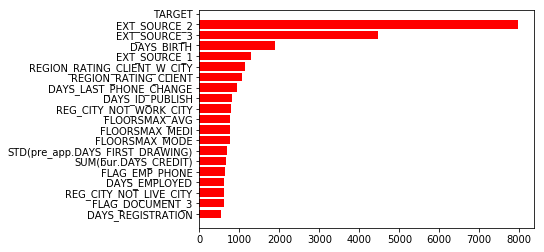

['TARGET' 'DAYS_BIRTH' 'DAYS_EMPLOYED' 'DAYS_REGISTRATION'
 'DAYS_ID_PUBLISH' 'FLAG_EMP_PHONE' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'REG_CITY_NOT_LIVE_CITY'
 'REG_CITY_NOT_WORK_CITY' 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3'
 'FLOORSMAX_AVG' 'FLOORSMAX_MODE' 'FLOORSMAX_MEDI'
 'DAYS_LAST_PHONE_CHANGE' 'FLAG_DOCUMENT_3'
 'STD(pre_app.DAYS_FIRST_DRAWING)' 'SUM(bur.DAYS_CREDIT)'
 'SUM(bur.DAYS_CREDIT_ENDDATE)' 'SUM(bur.DAYS_ENDDATE_FACT)'
 'SUM(bur.DAYS_CREDIT_UPDATE)' 'STD(bur.DAYS_CREDIT)'
 'STD(bur.DAYS_ENDDATE_FACT)' 'STD(bur.DAYS_CREDIT_UPDATE)'
 'MAX(bur.DAYS_CREDIT)' 'MIN(bur.DAYS_CREDIT)'
 'MIN(bur.DAYS_ENDDATE_FACT)' 'MIN(bur.DAYS_CREDIT_UPDATE)'
 'MEAN(bur.DAYS_CREDIT)' 'MEAN(bur.DAYS_ENDDATE_FACT)'
 'MEAN(bur.DAYS_CREDIT_UPDATE)' 'STD(install_pay.DAYS_INSTALMENT)'
 'STD(install_pay.DAYS_ENTRY_PAYMENT)'
 'STD(cc_bal.AMT_DRAWINGS_ATM_CURRENT)'
 'STD(cc_bal.AMT_INST_MIN_REGULARITY)'
 'STD(cc_bal.CNT_DRAWINGS_ATM_CURRENT)' 'STD(cc_bal.CNT_DRAWINGS_CURRENT)'
 'STD

In [24]:
##Why were they selected
scores = select.scores_
selected_feature_Scores = scores[feature_mask]

p_values = select.pvalues_
selected_feature_pvalues = p_values[feature_mask]

features_df = pd.DataFrame({'Features':features_selected
                           ,'Scores':selected_feature_Scores
                           ,'P Values':selected_feature_pvalues
                           }
                          )
features_df.sample(10)

dset = features_df.head(20).sort_values('Scores')

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
y_pos = np.arange(len(dset['Scores']))
ax.barh(y_pos,dset['Scores'],color='r')
ax.set_yticks(y_pos)
ax.set_yticklabels(dset['Features'])

plt.show()

### Splitting test and training datasets

Now that we know what features we want to use we can drop the unrequired features and set up our training and test datasets.

SK Learn has a function that makes this easy by not only specifying what percentages should be used for the test dataset but also stratifying the sample on the outcome varibles. Meaning if the overall sample has 4% of accounts with a target value of 1, then SK Learn will maintain this 4% in both the test and training data. As a general rule a 30:70 split for Test:Training data is a good starting point.

In [84]:
from sklearn.model_selection import train_test_split

reduced_features = apps[good_features]

# train_test_split(dataset, target, random seed, sample rate)
x_train, x_test, y_train, y_test = train_test_split(reduced_features, reduced_features['TARGET'], random_state = 1234, test_size= 0.3)


In [73]:
x_train.sample(10)
# size = x_train.shape
# print(size)

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,MEAN(pre_app.MAX(pos_cash.SK_DPD_DEF)),CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
206255,0,-21605,-7554,-10846.0,-4462,1,2,2,0,0,...,0.0,0,1,0,1,0,1,0,0,1
223148,0,-17892,-8606,-11152.0,-1428,1,2,2,0,1,...,1.2,1,0,0,0,1,0,0,0,0
113857,0,-20095,365243,-2122.0,-3605,0,2,2,0,0,...,0.0,1,0,1,0,1,0,0,1,1
332022,0,-19194,-12447,-10304.0,-2720,1,1,1,0,0,...,0.0,1,0,0,0,0,1,0,0,0
333744,0,-12313,-530,-6342.0,-219,1,3,3,0,1,...,0.0,0,1,0,1,0,1,0,0,0
322079,0,-23646,-2225,-12902.0,-4951,1,2,2,0,1,...,0.0,1,0,0,1,1,0,0,0,0
332390,0,-14008,-7233,-342.0,-4293,1,2,2,0,0,...,0.0,1,0,0,1,0,1,1,0,1
149268,0,-8752,-951,-3281.0,-828,1,2,2,1,1,...,0.0,1,0,0,1,0,1,1,0,0
421278,1,-14011,-556,-2085.0,-4457,1,2,2,0,0,...,0.0,0,1,0,0,0,1,1,0,1


In [ ]:
x_test.sample(10)
size = x_test.shape
print(size)

In [ ]:
y_train.sample(10)
size = y_train.shape
print(size)

In [ ]:
y_test.sample(10)
size = y_test.shape
print(size)

In [48]:
x_train.to_pickle(data_location+'x_train.pkl')
x_test.to_pickle(data_location+'x_test.pkl')

y_train.to_pickle(data_location+'y_train.pkl')
y_test.to_pickle(data_location+'y_test.pkl')

In [113]:
#Import data
# x_train = pd.read_pickle(data_location+'x_train.pkl')
x_test = pd.read_pickle(data_location+'x_test.pkl')

# y_train = pd.read_pickle(data_location+'y_train.pkl')
# y_test = pd.read_pickle(data_location+'y_test.pkl')

# Building Models

Now that we have done most of our data preparation we can start training some models. My inital thought was to use some clustering to carry out segmentaion. So the first thing we are going to investigate is KMeans clustering.

## K Means Clustering
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>N</mi>
</math> samples <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>X</mi>
</math> into <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>K</mi>
</math> disjoint clusters <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>C</mi>
</math>, each described by the mean  of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>X</mi>
</math>, although they live in the same space. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum of squared criterion:

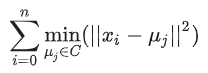

Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

* Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
* Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

###### Basically its iterative pythogorus.


Because of this we are going to have to scale our data to avoid the large value dominating the clustering. This scaling is done using SK Learns standard scaler. The scaling is done using Z-Scores,
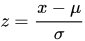

for each value in a given column we subtract the mean value of that column (thus centering the data around 0) and divide by the standard deviation. This gives low value numbers that retain their relative importance compared to each other. 

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# print(x_train.head(10))

scaled_train = x_train.copy() #you have to use copy otherwise you are just aliasing the dataframe
col_list = scaled_train.columns

scaled_train[col_list] = scaler.fit_transform(scaled_train[col_list])
scaled_train.head(10)
# print(x_train.head(10))

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,MEAN(pre_app.MAX(pos_cash.SK_DPD_DEF)),CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
335327,-0.296430,-1.010389,2.132734,-0.347202,-0.339174,-2.132706,-0.103704,-0.063678,-0.291750,-0.547839,...,-0.178244,0.72223,-0.722200,2.133108,-1.032686,-0.567914,0.639408,-0.467893,2.132974,0.965722
223999,-0.296430,-0.923998,-0.545501,-1.995131,0.061014,0.468888,-0.103704,-0.063678,-0.291750,-0.547839,...,-0.178244,-1.38460,1.384657,-0.468800,0.968348,-0.567914,0.639408,2.137243,-0.468829,0.965722
331727,-0.296430,0.717875,-0.455078,-0.201521,-1.107748,0.468888,-2.068076,-2.052528,-0.291750,1.825352,...,-0.178244,0.72223,-0.722200,-0.468800,0.968348,1.760830,-1.563947,-0.467893,-0.468829,0.965722
450346,-0.296430,1.199324,-0.471687,0.973300,1.307297,0.468888,-0.103704,-0.063678,-0.291750,-0.547839,...,-0.178244,0.72223,-0.722200,-0.468800,0.968348,-0.567914,0.639408,2.137243,-0.468829,0.965722
242070,-0.296430,-1.706094,2.132734,-0.474992,-0.799656,-2.132706,-0.103704,-0.063678,-0.291750,-0.547839,...,-0.178244,0.72223,-0.722200,2.133108,-1.032686,-0.567914,0.639408,-0.467893,2.132974,0.965722
119210,-0.296430,0.515763,-0.466577,1.180889,-1.671590,0.468888,-0.103704,-0.063678,-0.291750,-0.547839,...,-0.178244,0.72223,-0.722200,-0.468800,-1.032686,-0.567914,0.639408,-0.467893,-0.468829,0.965722
135115,-0.296430,0.667462,-0.463648,0.925308,1.118466,0.468888,-0.103704,-0.063678,-0.291750,1.825352,...,-0.178244,-1.38460,1.384657,-0.468800,-1.032686,-0.567914,0.639408,-0.467893,-0.468829,0.965722
329077,-0.296430,0.768060,-0.456465,-0.524973,1.239715,0.468888,-0.103704,-0.063678,-0.291750,-0.547839,...,-0.178244,0.72223,-0.722200,-0.468800,0.968348,-0.567914,0.639408,-0.467893,-0.468829,-1.035495
162091,3.373476,-1.384594,2.132734,-1.675087,-0.981198,-2.132706,-0.103704,-0.063678,3.427596,-0.547839,...,-0.178244,0.72223,-0.722200,2.133108,-1.032686,-0.567914,0.639408,-0.467893,2.132974,-1.035495


As you can see, now all the different features have a similar range (-10 to 10). 

Now we can carry out the clustering but we need to decide how many clusters we want to have. 

To select the best number of clusters I am running the k means algorithm for a range of k values. Then by plotting these values against the total distance to the centroid of each cluster for each member of the cluster (the error/within sum of squares), and then looking at where the gradient changes, we can make a judgment on what the best number of clusters is. I would not go above say 10 clusters as that seems excessive and you start to have a hard time interpreting what each cluster represents but for illustrative purposes we will extend the elbow curve out to 30 clusters.

###### This is known as the elbow method.


In [59]:
from sklearn.cluster import KMeans
#Define range of cluster we want to test
## Not we can ignore one cluster as we already have that being the sample
Nc = range(2, 30)

#initalise algorithm
kmeans = [KMeans(n_clusters=i) for i in Nc]

#output values to confirm everything worked correctly
kmeans

#Carry out clustering and record the error in array
score = [kmeans[i].fit(scaled_train.drop('TARGET',axis = 1)).score(scaled_train.drop('TARGET',axis = 1)) for i in range(len(kmeans))]

#output values to confirm everything worked correctly
print(list(Nc))
print(score)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[-21468345.639200468, -19242175.88381682, -17287807.413218584, -15880410.16466124, -15100497.2785187, -14572822.095919475, -14074545.393365687, -13613238.508534241, -13245244.141107278, -12834151.443377659, -12565560.878578153, -12353584.65164759, -11965987.23538632, -11742582.209775336, -11547810.401298754, -11355880.330431255, -11227631.116777323, -11107910.733215727, -10982508.807366008, -10840444.0232114, -10783249.855660187, -10645446.537817366, -10546242.048525156, -10411970.162219504, -10360206.19532403, -10303502.736130692, -10188784.614708168, -10094766.760698175]


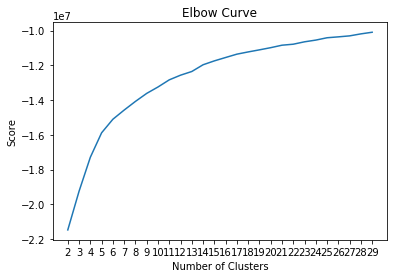

In [60]:
##Plot the elbow curve
plt.plot(list(Nc),score)
plt.xticks(list(Nc))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

From the Elbow curve we can see that 5 clusters seems to be a sweet spot so that's how many we will use for segmentation.

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)

clust = kmeans.fit(scaled_train.drop('TARGET',axis = 1)).predict(scaled_train.drop('TARGET',axis = 1))

##Add the clusters on to the unscaled training dataset
x_train['clusters'] = pd.Series(clust, index=x_train.index)

# x_train.head(10)

In [111]:
#Check that each cluster has suitable volumes of target
clusters_counts = x_train.groupby('clusters',as_index=False)['TARGET'].count().rename(index=str,columns={'TARGET':'count'})
clusters_sum = x_train.groupby('clusters',as_index=False)['TARGET'].sum().rename(index=str,columns={'TARGET':'sum'})

print(clusters_counts)
print(clusters_sum)

   clusters   count
0         0    3574
1         1   72845
2         2  117006
3         3    4438
4         4   17394
   clusters   sum
0         0   563
1         1  4238
2         2  9978
3         3   654
4         4  1954


It would be useful to look at these clusters however we do not have a 138 axis chart. We will need to reduce these dimensions down to just 2. Luckily there is a method for doing this, Principal component analysis.

# Principal Component Analysis 

PCA is used to decompose a multivariable dataset in a set of successive orthogonal components that explain a maximum amount of the variance. 

It is important to note that we are going to be using the scaled data for this. This is to stop varibles with a large variance (and sparsely populated in this case) from dominating the Principal Compenents. This can be seen in the example below.

###### Unscaled Data

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x_train.drop('TARGET',axis = 1))

# print(principalComponents[:,1]) #note the slicing, this will give all of the column 1 in the array. (the : means all regardless of length)
# print(principalComponents[:,0]) #note the slicing this will give all of the column 0 in the array.

x_train['pc1'] = pd.Series(principalComponents[:,0], index=x_train.index)
x_train['pc2'] = pd.Series(principalComponents[:,1], index=x_train.index)

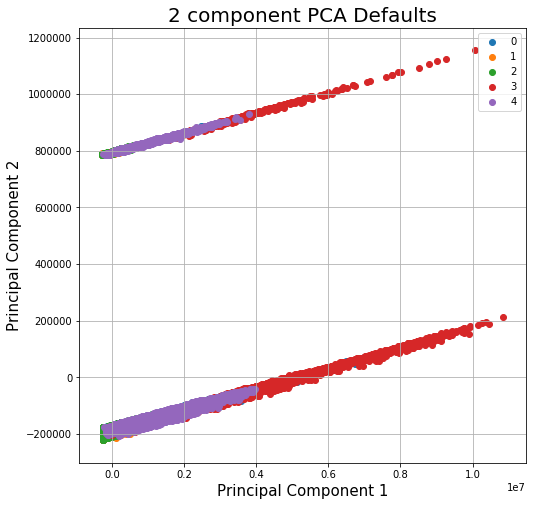

In [125]:
# using unscaled data
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA Defaults', fontsize = 20)

targets = [0,1,2,3,4]
colors = ['blue','orange','green','red','purple']
# Zip is just a container to allow both to be iterated using the same index
for target,color in zip(targets,colors):
    indicesToKeep = x_train['clusters'] == target
    ax.scatter(x_train.loc[indicesToKeep, 'pc1']
              , x_train.loc[indicesToKeep, 'pc2']
              )
ax.legend(targets)
ax.grid()

###### Scaled Data

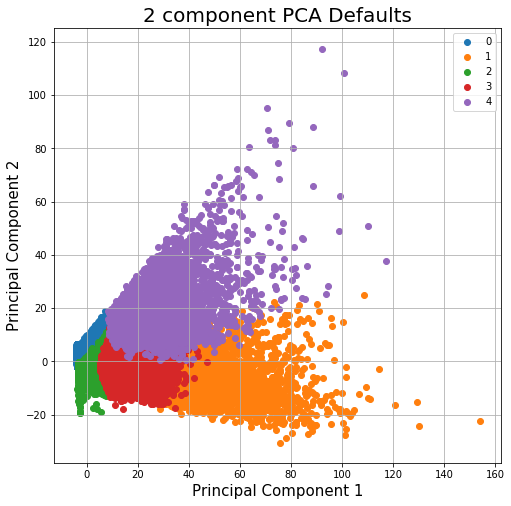

In [8]:
from sklearn.decomposition import PCA

#using scaled data
scaled_train['clusters'] = pd.Series(clust, index=scaled_train.index)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(scaled_train.drop('TARGET',axis = 1))

# print(principalComponents[:,1]) #note the slicing, this will give all of the column 1 in the array. (the : means all regardless of length)
# print(principalComponents[:,0]) #note the slicing this will give all of the column 0 in the array.

scaled_train['pc1'] = pd.Series(principalComponents[:,0], index=scaled_train.index)
scaled_train['pc2'] = pd.Series(principalComponents[:,1], index=scaled_train.index)
# 
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA Defaults', fontsize = 20)

targets = [0,1,2,3,4]
colors = ['blue','orange','green','red','purple']
# Zip is just a container to allow both to be iterated using the same index
for target,color in zip(targets,colors):
    indicesToKeep = scaled_train['clusters'] == target
    ax.scatter(scaled_train.loc[indicesToKeep, 'pc1']
              , scaled_train.loc[indicesToKeep, 'pc2']
              )
ax.legend(targets)
ax.grid()

So now that we have our segments we need to know how they are defined. The reason for this is pretty simple, we need to be able to assign other accounnts to a cluster without running the clustering again. To do this we can use another machine learning technique decision tree.

# Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


For this we are going to use unscaled data as this is will make it easy to apply the rules.

In [118]:
from sklearn.tree import DecisionTreeClassifier

# create decision tree
tree_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)

tree_model.fit(x_train.drop(['TARGET','clusters','pc1','pc2','cluster__0','cluster__1','cluster__2','cluster__3','cluster__4'],axis = 1),x_train['clusters'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [117]:
x_train.drop(['TARGET','clusters','pc1','pc2'],axis = 1).columns

Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1',
       ...
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'OCCUPATION_TYPE_Laborers', 'ORGANIZATION_TYPE_XNA',
       'EMERGENCYSTATE_MODE_No', 'cluster__0', 'cluster__1', 'cluster__2',
       'cluster__3', 'cluster__4'],
      dtype='object', length=141)

# Evaluate the model

In [18]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = tree_model.predict(x_train.drop(['TARGET','clusters','pc1','pc2'],axis = 1))
print(probs)

x_train['pred_cluster'] = pd.Series(probs, index=x_train.index)


[0 3 3 ... 0 0 0]


In [19]:
# x_train.head(10)

tree_result = x_train[['clusters','pred_cluster']].copy()
tree_result.head(10)


tree_summary = pd.crosstab(tree_result['clusters'],tree_result['pred_cluster'])
tree_summary

pred_cluster,0,1,2,3,4
clusters,,,,,
0,115763,0,1034,212,0
1,1,4193,3,231,10
2,1453,0,71011,378,0
3,226,54,385,16702,27
4,29,4,17,89,3435


Given that we have above 95% match rates between the actual and predicted clusters, I would be happy going forward on this basis. It is worth noting we have not carried out any stability analysis on these clusterings through time so the level of variance is unknown.  Now that we have a decision tree model we need to get the rule set that defines each of the leaves. This can be done using the following code, which produced a function that defines the tree in the log. One of the main advantages of decison tree model is it is highly interpretable. 

###### Get Decison Tree Code

In [21]:
from sklearn.tree import _tree

col_list = x_train.drop(['TARGET','clusters'],axis=1).columns.values

# print(col_list)

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
tree_to_code(tree_model,col_list)

def tree(DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, FLAG_EMP_PHONE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, FLOORSMAX_AVG, FLOORSMAX_MODE, FLOORSMAX_MEDI, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_3, STD(pre_app.DAYS_FIRST_DRAWING), SUM(bur.DAYS_CREDIT), SUM(bur.DAYS_CREDIT_ENDDATE), SUM(bur.DAYS_ENDDATE_FACT), SUM(bur.DAYS_CREDIT_UPDATE), STD(bur.DAYS_CREDIT), STD(bur.DAYS_ENDDATE_FACT), STD(bur.DAYS_CREDIT_UPDATE), MAX(bur.DAYS_CREDIT), MIN(bur.DAYS_CREDIT), MIN(bur.DAYS_ENDDATE_FACT), MIN(bur.DAYS_CREDIT_UPDATE), MEAN(bur.DAYS_CREDIT), MEAN(bur.DAYS_ENDDATE_FACT), MEAN(bur.DAYS_CREDIT_UPDATE), STD(install_pay.DAYS_INSTALMENT), STD(install_pay.DAYS_ENTRY_PAYMENT), STD(cc_bal.AMT_DRAWINGS_ATM_CURRENT), STD(cc_bal.AMT_INST_MIN_REGULARITY), STD(cc_bal.CNT_DRAWINGS_ATM_CURRENT), STD(cc_bal.CNT_DRAWINGS_CURRENT), STD(cc_bal.CNT_DRAWINGS_POS_CURRENT), MAX(cc_bal.AMT_BALANCE)

          if MEAN(bur.DAYS_CREDIT_UPDATE) <= -281.5:
            return [[ 2.  0. 18.  1.  1.]]
          else:  if MEAN(bur.DAYS_CREDIT_UPDATE) > -281.5
            return [[135.   0.  36.   2.   2.]]
  else:  if pc1 > 0.5
    if pc1 <= 2.5:
      if pc1 <= 1.5:
        if SUM(pre_app.MEAN(cc_bal.AMT_RECEIVABLE_PRINCIPAL)) <= 191464.0:
          if MEAN(pre_app.MEAN(cc_bal.AMT_DRAWINGS_ATM_CURRENT)) <= 28301.78515625:
            return [[ 0. 21.  0. 30.  1.]]
          else:  if MEAN(pre_app.MEAN(cc_bal.AMT_DRAWINGS_ATM_CURRENT)) > 28301.78515625
            return [[  0. 208.   0.  24.   0.]]
        else:  if SUM(pre_app.MEAN(cc_bal.AMT_RECEIVABLE_PRINCIPAL)) > 191464.0
          if MAX(cc_bal.AMT_BALANCE) <= 294500.53125:
            return [[  0. 189.   0.  12.   0.]]
          else:  if MAX(cc_bal.AMT_BALANCE) > 294500.53125
            return [[   0. 3796.    0.   18.    4.]]
      else:  if pc1 > 1.5
        if STD(pos_cash.MONTHS_BALANCE) <= 13.885428428649902:
          if M

###### Print Tree Diagram

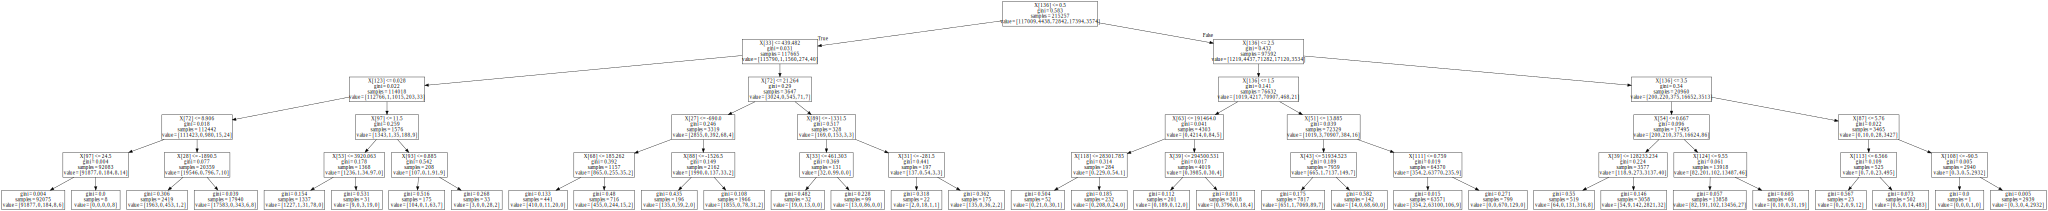

In [20]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(tree_model,out_file=None)
graph = graphviz.Source(dot_data)
graph

So now we have some level of segmentation that we can use in a logistic regression; however, since we have the decison tree framework in place it's simply to see how a sole decision tree model would perform.

## Decision Tree to find target

In [34]:
import sklearn.tree

# create decision tree
tar_tree_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1)
tar_tree_model.fit(x_train.drop(['TARGET','clusters','pc1','pc2','pred_cluster'],axis = 1),x_train['TARGET'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

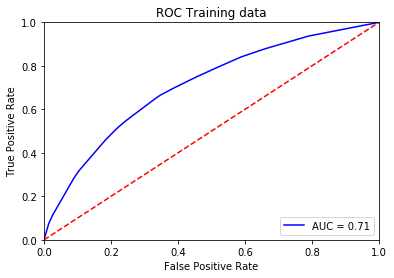

In [35]:
# calculate the fpr and tpr for all thresholds of the classification
probs = tar_tree_model.predict_proba(x_train.drop(['TARGET','clusters','pc1','pc2','pred_cluster'],axis = 1))
# print(probs)
preds = probs[:,1]
# print(preds)
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
# print(fpr)
roc_auc = metrics.auc(fpr, tpr)
# print(roc_auc)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Training data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Test Data

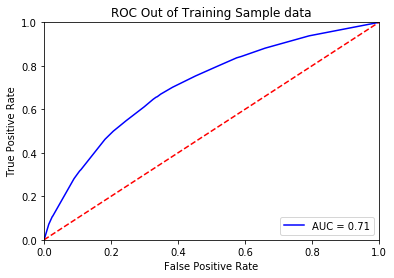

In [36]:
# calculate the fpr and tpr for all thresholds of the classification
probs = tar_tree_model.predict_proba(x_test.drop(['TARGET'],axis=1))
# print(probs)
preds = probs[:,1]
# print(preds)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# print(fpr)
roc_auc = metrics.auc(fpr, tpr)
# print(roc_auc)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Out of Training Sample data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

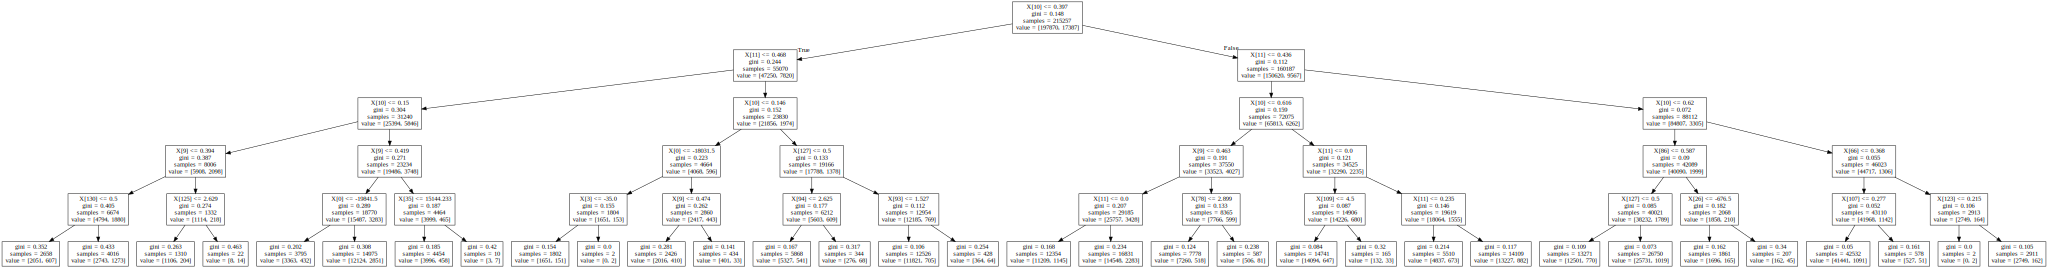

In [38]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(tar_tree_model,out_file=None)
graph = graphviz.Source(dot_data)
graph

# Logistic Regression with Segmentaion

Logistic regression is vey widely used in credit scoring models particularly in probablitiy of default components of expected loss modeling. 

Logistic regression is an alternative method to use other than the simpler Linear Regression. Linear regression tries to predict the data by finding a linear – straight line – equation to model or predict future data points. Logistic regression does not look at the relationship between the two variables as a straight line. Instead, Logistic regression uses the natural logarithm function to find the relationship between the variables and uses test data to find the coefficients. This is benificial as in general defaults follow a logistic distibution.

Logistic regression uses the concept of odds ratios to calculate the probability. This is defined as the ratio of the odds of an event happening to its not happening.

Now that we have both a segmentation and a benchmark for prediction we can move onto using logistic regression. To do this we need to one hot encode the clusters as they are catagorical. 

After we have these dummies and we present them to the logistic classifier, we are taking account of the segmentation of the k means. In essence we have used the K means algorithm as another feature generation method.

NB You may have noticed I have been leaving out the actual clusters and both principal components from models, this is because the componets should be derivitive of the other features. The clusters are not definable in themselves only the predicted clusters are, so we can't include the inherent error in this feature as that is what will be available going forward. 


In [42]:
x = pd.get_dummies(x_train['pred_cluster'],prefix='cluster_')
x_train = x_train.join(x,on='SK_ID_CURR').drop(str('pred_cluster'),1)
x_train.head(10)

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,clusters,pc1,pc2,cluster__0,cluster__1,cluster__2,cluster__3,cluster__4
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
335327,0,-20446,365243,-6204.0,-3506,0,2,2,0,0,...,1,1,0,-1.070699e+05,298300.886115,1,0,0,0,0
223999,0,-20069,-13228,-12007.0,-2902,1,2,2,0,0,...,0,1,1,2.456213e+05,-72759.956391,0,0,0,1,0
331727,0,-12904,-450,-5691.0,-4666,1,1,1,0,1,...,0,1,3,1.091074e+06,-29075.749471,0,0,0,1,0
450346,0,-10803,-2797,-1554.0,-1021,1,2,2,0,0,...,0,1,2,-9.488122e+04,-69669.475750,0,0,1,0,0
242070,0,-23482,365243,-6654.0,-4201,0,2,2,0,0,...,1,1,3,1.341957e+05,302671.006014,0,0,1,0,0
119210,0,-13786,-2075,-823.0,-5517,1,2,2,0,0,...,0,1,0,-9.491287e+04,-68869.502094,1,0,0,0,0
135115,0,-13124,-1661,-1723.0,-1306,1,2,2,0,1,...,0,1,2,-9.492631e+04,-68455.585645,0,0,1,0,0
329077,0,-12685,-646,-6830.0,-1123,1,2,2,0,0,...,0,0,4,1.088094e+05,-62502.690815,0,0,0,0,1
162091,1,-22079,365243,-10880.0,-4475,0,2,2,1,0,...,1,0,0,-1.070662e+05,298317.323803,1,0,0,0,0


In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
model = clf.fit(x_train.drop(['TARGET','clusters','pc1','pc2'],axis = 1),y_train)


In [114]:
model_estimates = pd.DataFrame(data = x_train.drop(['TARGET','clusters','pc1','pc2'],axis = 1).columns,columns = ['features'])
coeffs = pd.DataFrame(data = model.coef_.transpose(),columns = ['coefficents'])

# print(model.coef_[0,:])
# print(model.pvalues_)

model_estimates['coefficents'] = pd.Series(model.coef_[0,:], index=model_estimates.index)

model_estimates.sort_values(by=['coefficents'],axis=0)

,features,coefficents
90,MIN(pre_app.MEAN(install_pay.DAYS_INSTALMENT)),-0.004971
131,NAME_EDUCATION_TYPE_Higher education,-0.002049
10,EXT_SOURCE_2,-0.001958
127,CODE_GENDER_F,-0.001814
135,EMERGENCYSTATE_MODE_No,-0.001491
68,STD(pre_app.MAX(install_pay.DAYS_INSTALMENT)),-0.001308
9,EXT_SOURCE_1,-0.001211
136,cluster__0,-0.001194
11,EXT_SOURCE_3,-0.001147
4,FLAG_EMP_PHONE,-0.001005


In [100]:
print('The intercept is '+str(model.intercept_[0]))

The intercept is -0.0010155924897856479


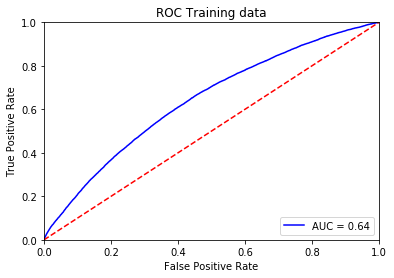

In [101]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(x_train.drop(['TARGET','clusters','pc1','pc2'],axis = 1))
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Training data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [121]:
#Set up the test data to run through the model
test_probs = tree_model.predict(x_test.drop(['TARGET'],axis = 1))

x_test['pred_cluster'] = pd.Series(test_probs, index=x_test.index)

x = pd.get_dummies(x_test['pred_cluster'],prefix='cluster_')
x_test = x_test.join(x,on='SK_ID_CURR').drop(str('pred_cluster'),1)

x_test.sample(10)

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Laborers,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,cluster__0,cluster__1,cluster__2,cluster__3,cluster__4
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
287366,0,-10598,-2632,-4607.0,-2177,1,2,2,1,1,...,1,0,0,0,0,1,0,0,0,0
240366,0,-14774,-777,-1098.0,-4716,1,2,2,0,0,...,0,1,0,0,1,1,0,0,0,0
301805,0,-18079,-102,-6133.0,-1613,1,2,2,0,0,...,0,1,0,0,1,1,0,0,0,0
375139,0,-18122,-2769,-3072.0,-1666,1,2,2,0,0,...,1,0,0,0,1,1,0,0,0,0
180165,0,-10965,-156,-4994.0,-3325,1,3,3,0,1,...,1,0,0,0,0,1,0,0,0,0
268084,0,-20066,365243,-6016.0,-3483,0,2,1,0,0,...,0,1,0,1,1,1,0,0,0,0
430032,0,-10683,-2643,-4942.0,-3363,1,1,1,0,0,...,0,1,1,0,1,0,0,1,0,0
250780,0,-8690,-440,-989.0,-1001,1,2,2,0,0,...,0,1,0,0,1,0,0,1,0,0
304566,0,-23417,365243,-697.0,-3164,0,2,2,0,0,...,0,1,0,1,1,0,0,1,0,0


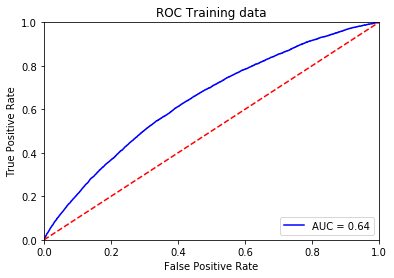

In [123]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(x_test.drop(['TARGET'],axis = 1))
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC Training data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So despite giving the logistic regression ample features the model produced is not as good as a straight decison tree. ROC AUC of 0.64 vs 0.71.